In [270]:
import simpy
import numpy as np
import rbfopt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [192]:
class Factory:
    def __init__(
            self, 
            env:simpy.Environment, 
            num_stages:int, 
            machine_times:list[float], 
            n_machines:list[int]
            ) -> None:
        self.env = env

        self.machines = [simpy.Resource(env, n_machines[i]) for i in range(num_stages)]
        
        self.machine_times = machine_times
        self.n_machines = n_machines
        self.num_stages = num_stages

    def produce(self, m_id):
        rt = np.random.exponential(scale=1.0/self.machine_times[m_id])
        print("production time: ", rt, m_id)
        yield self.env.timeout(rt)

In [219]:
def manufacture(env:simpy.Environment, product_id:int, processor:Factory, data:list):

    for i in range(processor.num_stages):
        with processor.machines[i].request() as request:
            # yield can also be seen as a 'wait for' statement
            # wait for the machine to be ready
            yield request
            # wait for the factory to process the product
            yield env.process(processor.produce(i))
        print(f"product id {product_id} finished processing stage {i} at {env.now}")    
    data.append([product_id, env.now])
    

In [220]:
def setup(env:simpy.Environment, num_stages, num_machines, machine_times, delivery_interval:float, data):
    factory = Factory(env, num_stages,machine_times, num_machines)
    i = 0
    while True:
        # wait for the next product to be delivered
        yield env.timeout(np.random.exponential(1.0/delivery_interval))
        # print(f"product {i} delivered at {env.now}")
        # if a new product is delivered, launch a new process that handles this product.
        env.process(manufacture(env, i, factory, data))

In [221]:
def price(demand):
    return 100 - demand

In [ ]:
fig, ax = plt.subplots()
# ax.plot(output, price(output))
output = np.arange(0,100,1)

ax.plot(output, output*price(output))
ax.set_xlabel('Supply')
ax.set_ylabel('Revenue')

In [223]:
NUM_MACHINES = [3, 5]
MACHINE_TIMES = [0.1,0.2]

DELIVERY_RATE = 1
MACHINE_COSTS = [300,200]
SIM_TIME = 120

def run(num_machines):
    data = []
    env = simpy.Environment()
    env.process(setup(env, len(num_machines), num_machines, MACHINE_TIMES, DELIVERY_RATE, data))
    env.run(until=SIM_TIME)
    return len(data)

In [224]:
def obj(num_machines):
    products_handled = run(num_machines)
    return -(
        products_handled * price(products_handled) 
        - sum([MACHINE_COSTS[i]*num_machines[i] for i in range(len(num_machines))]))

In [265]:
z = np.zeros((5,5))
x = np.arange(0,5)
y = np.arange(0,5)

In [266]:
x, y = np.meshgrid(x, y)

In [ ]:
for i in range(1, 5):
    for j in range(1,5):
        z[i, j] = -sum([obj([i,j]) for _ in range(50)])/50
        # res.append({"s1":i, "s2": j, "obj": sum([obj([i,j]) for _ in range(50)])/50})

Text(0.5, 0.5, 'Machines Stage 0')

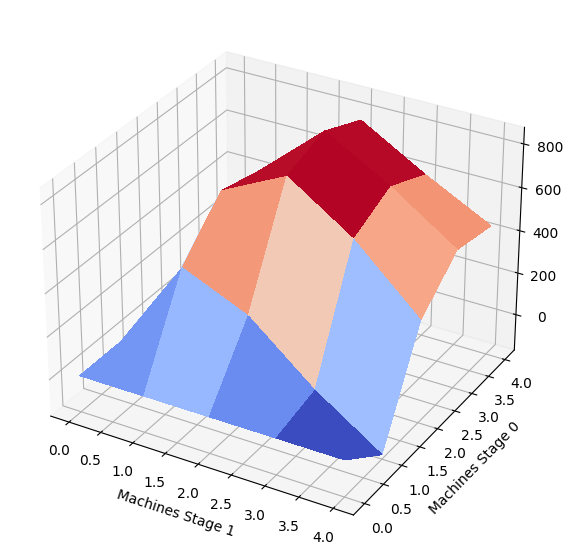

In [278]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7,7))
surf = ax.plot_surface(x,y,z,linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_xlabel('Machines Stage 1')
ax.set_ylabel('Machines Stage 0')

In [228]:
NDIM = 2
max_fun_calls = 8
lbounds = [1,1]
ubounds = [10, 10]

bb = rbfopt.RbfoptUserBlackBox(
    dimension=NDIM, 
    var_lower=np.array(lbounds, dtype=np.float), 
    var_upper=np.array(ubounds, dtype=np.float), 
    var_type=['N'] * NDIM, obj_funct=obj)

settings = rbfopt.RbfoptSettings(max_evaluations=max_fun_calls)

alg = rbfopt.RbfoptAlgorithm(settings, bb)

/tmp/ipykernel_10193/683785468.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  var_lower=np.array(lbounds, dtype=np.float),
/tmp/ipykernel_10193/683785468.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  var_upper=np.array(ubounds, dtype=np.float),


In [ ]:
fval, sol, iter_count, eval_count, fast_eval_count = alg.optimize()

In [258]:
fval

-671.0

In [230]:
sol

array([3., 1.])

In [231]:
fval

-671.0